---
title: "MNIST (one vs REST) Classifier"
author: "Vannsh Jani"
date: "10/18/2023"
format: 
  html:
    code-fold: true
jupyter: python3
---

In this blog let's build a MNIST Classifier (one vs REST) where we will classify whether a given image is of the digit 2 or not.

Let's first import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.autograd import Variable

In [2]:
# Download MNIST dataset
mnist_data = MNIST(root='./data', download=True)


In [3]:
# 60000 images of size 28x28
data = mnist_data.data.numpy()
data.shape

(60000, 28, 28)

In [4]:
train_image,test_image,train_label,test_label = train_test_split(data, mnist_data.targets.numpy(), test_size=0.2, random_state=42)
train_image.shape, train_label.shape, test_image.shape, test_label.shape

((48000, 28, 28), (48000,), (12000, 28, 28), (12000,))

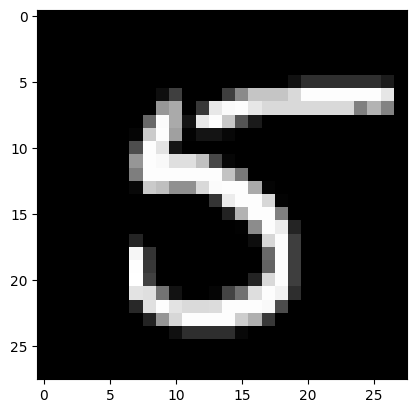

In [5]:
sample_image = train_image[0]
plt.imshow(sample_image, cmap='gray')

In [6]:
print(train_label[12:17])
# 1 as label for digit 2 and 0 otherwise
train_label[train_label!=2] = 0
train_label[train_label==2] = 1
test_label[test_label!=2] = 0
test_label[test_label==2] = 1


# Convert to torch tensors
train_image = torch.from_numpy(train_image).long()
test_image = torch.from_numpy(test_image).long()
train_label = torch.from_numpy(train_label).float()
test_label = torch.from_numpy(test_label).float()
train_label[12:17] 

[8 1 1 2 6]


tensor([0., 0., 0., 1., 0.])

In [7]:
train_image = train_image.view(-1, 1,28,28).float()
test_image = test_image.view(-1,1,28,28).float()

train_image = train_image/255.
test_image = test_image/255.

train = torch.utils.data.TensorDataset(train_image,train_label)
test = torch.utils.data.TensorDataset(test_image,test_label)

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [8]:
# Define the model
class cnn_Model(nn.Module):
    def __init__(self):
        super(cnn_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.pool = nn.MaxPool2d(2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        self.R = nn.ReLU()
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.S = nn.Sigmoid()
        
    def forward(self, x):

        x = self.conv1(x)
        x = self.R(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.R(x)
        x = self.pool(x)
        x = x.view(-1, 400)

        x = self.fc1(x)
        x = self.R(x)
        x = self.fc2(x)
        x = self.R(x)
        x = self.fc3(x)
        # x = self.S(x)
       

        return x.squeeze()
    
model = cnn_Model()

In [9]:
def accuracy(y_pred,y_true):
    y_pred = y_pred.detach().numpy()
    y_true = y_true.detach().numpy()
    y_pred[y_pred>=0.5] = 1
    y_pred[y_pred<0.5] = 0
    return y_pred,y_true

In [10]:
def fit(model, train_loader,learning_rate=0.001):
    optimizer = Adam(model.parameters(),lr=learning_rate)
    error = nn.BCEWithLogitsLoss()
    EPOCHS = 5
    predictions = []
    model.train()
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            y_pred,y_true = accuracy(output.data,var_y_batch)
            predictions.extend(y_pred)
            correct += (output.data == var_y_batch).sum()
            if batch_idx % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data.item(), float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
fit(model, train_loader)

Epoch : 0 [0/48000 (0%)]	Loss: 0.689121	 Accuracy:92.188%
Epoch : 0 [3200/48000 (7%)]	Loss: 0.309166	 Accuracy:89.951%
Epoch : 0 [6400/48000 (13%)]	Loss: 0.099755	 Accuracy:90.362%
Epoch : 0 [9600/48000 (20%)]	Loss: 0.029480	 Accuracy:91.484%
Epoch : 0 [12800/48000 (27%)]	Loss: 0.109460	 Accuracy:92.942%
Epoch : 0 [16000/48000 (33%)]	Loss: 0.018932	 Accuracy:93.943%
Epoch : 0 [19200/48000 (40%)]	Loss: 0.031651	 Accuracy:94.669%
Epoch : 0 [22400/48000 (47%)]	Loss: 0.003253	 Accuracy:95.272%
Epoch : 0 [25600/48000 (53%)]	Loss: 0.050199	 Accuracy:95.687%
Epoch : 0 [28800/48000 (60%)]	Loss: 0.038582	 Accuracy:96.044%
Epoch : 0 [32000/48000 (67%)]	Loss: 0.027412	 Accuracy:96.367%
Epoch : 0 [35200/48000 (73%)]	Loss: 0.002585	 Accuracy:96.614%
Epoch : 0 [38400/48000 (80%)]	Loss: 0.019685	 Accuracy:96.802%
Epoch : 0 [41600/48000 (87%)]	Loss: 0.102819	 Accuracy:96.966%
Epoch : 0 [44800/48000 (93%)]	Loss: 0.005966	 Accuracy:97.093%
Epoch : 1 [0/48000 (0%)]	Loss: 0.064155	 Accuracy:98.438%
Epoch 

In [11]:
pred = fit(model,test_loader)

Epoch : 0 [0/12000 (0%)]	Loss: 0.059561	 Accuracy:98.438%
Epoch : 0 [3200/12000 (27%)]	Loss: 0.000492	 Accuracy:99.540%
Epoch : 0 [6400/12000 (53%)]	Loss: 0.001770	 Accuracy:99.613%
Epoch : 0 [9600/12000 (80%)]	Loss: 0.016674	 Accuracy:99.638%
Epoch : 1 [0/12000 (0%)]	Loss: 0.020312	 Accuracy:100.000%
Epoch : 1 [3200/12000 (27%)]	Loss: 0.000561	 Accuracy:99.786%
Epoch : 1 [6400/12000 (53%)]	Loss: 0.001089	 Accuracy:99.737%
Epoch : 1 [9600/12000 (80%)]	Loss: 0.002166	 Accuracy:99.762%
Epoch : 2 [0/12000 (0%)]	Loss: 0.016146	 Accuracy:98.438%
Epoch : 2 [3200/12000 (27%)]	Loss: 0.001253	 Accuracy:99.816%
Epoch : 2 [6400/12000 (53%)]	Loss: 0.001416	 Accuracy:99.783%
Epoch : 2 [9600/12000 (80%)]	Loss: 0.001637	 Accuracy:99.814%
Epoch : 3 [0/12000 (0%)]	Loss: 0.008504	 Accuracy:100.000%
Epoch : 3 [3200/12000 (27%)]	Loss: 0.000157	 Accuracy:99.877%
Epoch : 3 [6400/12000 (53%)]	Loss: 0.000318	 Accuracy:99.876%
Epoch : 3 [9600/12000 (80%)]	Loss: 0.000288	 Accuracy:99.897%
Epoch : 4 [0/12000 (0%